# Localization with a known map &mdash; Part 2 <br/> Basic Inference with Particle Filters
<!-- "Inference with Particle Filters: Defining the Localization Model and Basic Inference Techniques" -->


In the second part of this tutorial, our primary focus will be on defining the localization model and performing inference using Gen's particle filter package.
We will use the components established in Part 1, and will employ Gen's static modeling language, which enables us to construct an efficient model for localization.
Subsequently, we will apply particle filters to perform inference in our localization model (...also utilizing Gen's generative function combinators... Unfold to unfold the slam markov chain). Particle filters offer a standard approach for estimating therobot's position based on the known map and sensor observations.

Firstly, we will run a standard particle filter using a default proposal. This approach will allow us to obtain a decent estimate of the robot's position. In order to improve the accuracy of our inference, we will introduce a series of Metropolis-Hastings (MH) "drift" moves.

In the 3rd part of this tutorial, we will go beyond the standard approach and introduce improvements &mdash; namely "grid proposals" &mdash; to enhance the precision of our inference process, enabling more robust localization results.

In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
include("src/localization_part_1.jl")

Loading data from `../data/data_4.jld2`, and
populating Main namespace with variables:

_segs      Vector{Segment}
_boxes     Vector{Segment}
_center    Vector{Float64}
_xs        Vector{Vector{Float64}}
_hds       Vector{Float64}
_ps        Vector{Pose}
_dxs       Vector{Vector{Float64}}
_dhds      Vector{Float64}
_us        Vector{Control}
_T         Int64
Created a few new variables:

_obs_noise Float64
_fov       Float64
_as        Vector{Float64}
_zs        Vector{Vector{Float64}}
_ys        Vector{Vector{Vector{Float64}}}
(500, 500, 41)


  291.601 ms (500021 allocations: 207.90 MiB)


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any, Any, Any], true, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, Some(100.0)], var"##sensor_model#381", Bool[0, 0, 0, 0, 0, 0, 0], false)

In [3]:
#nbx --fname="src/localization_part_2.jl"
using GenParticleFilters

## Noisy controls

In [4]:
#nbx
function perturb(u::Control, x_noise, hd_noise)
    dx  = u.dx  + diagnormal([0.,0.], [x_noise, x_noise])
    dhd = u.dhd + normal(0, hd_noise)
    return Control(dx,dhd)
end

perturb (generic function with 1 method)

Create noisy controls, run the cell below till you are happy with the amount of noise.

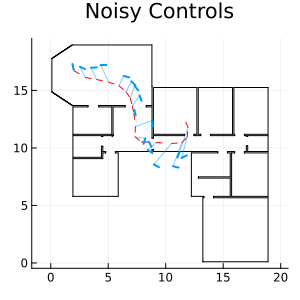

In [5]:
# x_noise  = 0.5
# hd_noise = 5/360*2π
# us_noisy = perturb.(_us, x_noise, hd_noise);

rel_ps = [p+u for (p,u) in zip(_ps[1:end-1],us_noisy)];
ps = [_ps[1]]
for u in us_noisy
    push!(ps, ps[end] + u)
end
# ---------------------
myplot = plot(size=(300,300), 
    title="Noisy Controls",
    aspect_ratio=1., legend=nothing)
plot!(_segs, c=:black)
plot!(_ps[1], c=:red)
plot!(_ps, c=:red)
for (p,q) in zip(_ps[2:end],ps)
    plot!(q, c=col[1], linewidth=2)
    plot!([p.x,q.x], c=col[1], alpha=0.5)
end
myplot

## Static Localization Model

```julia
     1          2        3          t        model-time

    prior     chain 
     0          1        2          t-1      chain-time

               u[1] --- u[2]  ...  u[t-1]
                |        |          |
    p[1] - - - p[2] --- p[3]  ...  p[t]
     |          |        |          |
    y[1]       y[2]     y[3]  ...  y[t] 
     |          |        |          |
     m          m        m          m
```

In [9]:
#nbx
@gen function slam_kernel(t, state, m, us, x_noise, hd_noise, w, s_noise, outlier, outlier_vol)
    
    p,_ = state
    u = us[t]

    p  = {:pose}   ~ motion_model(p, u, x_noise, hd_noise)
    x  = {:sensor} ~ sensor_model(p, m, w, s_noise, outlier, outlier_vol)
    
    state = (p, x)
return state
end

slam_chain = Gen.Unfold(slam_kernel)
Gen.@load_generated_functions

In [10]:
#nbx
@gen (static) function static_slam_model(T, 
        m,
        us, 
        p0, x0_noise, hd0_noise,  
        x_noise, hd_noise, 
        w, s_noise, outlier, outlier_vol)
    
    # Start the Markov chain; 
    # No motion, just the prior
    p  = { :pose   } ~ pose_prior_model(p0, x0_noise, hd0_noise)
    x  = { :sensor } ~ sensor_model(p, m, w, s_noise, outlier, outlier_vol) # GPU accelerated
    
    # Unfold the MArkov chain
    chain ~ slam_chain(T, (p, nothing), m, us, 
        x_noise, hd_noise, 
        w, s_noise, outlier, outlier_vol)
    
    return [(p,x);chain]
end

Gen.@load_generated_functions

In [11]:
#nbx
add_addr_prefix(t, addr) = t==0 ? addr : :chain => t => addr

add_addr_prefix (generic function with 1 method)

In [12]:
#nbx
function constraints(t::Int, _zs, _as)
    ch = choicemap()
    n = length(_zs[t+1])
    x = polar_inv(_zs[t+1],_as)
    ch[add_addr_prefix(t, :sensor => :x)] = x
    return ch
end

constraints (generic function with 1 method)

In [13]:
#nbx
get_pose(tr,t)     = tr[][t][1]
get_last_pose(tr)  = tr[][end][1]
get_first_pose(tr) = get_pose(tr,1)
get_obs(tr,t)      = tr[][t][2]
get_first_obs(tr)  = get_obs(tr,1)

get_first_obs (generic function with 1 method)

In [14]:
#nbx
function plot_slam_trace!(tr; show_obs=true)
    T,m, = get_args(tr)
    ps = get_pose.([tr],1:T+1)
    xs = get_obs.([tr],1:T+1)

    myplot = plot(size=(300,300), 
        title="A Trace",
        aspect_ratio=1., legend=nothing)
        
    plot!(_ps, c=:red)
    plot!(ps, c=col[1])
    plot!(_segs,  c=:black)
    plot!(_boxes, c=:magenta)
    if show_obs
        for (x,p) in zip(xs, ps)
            myplot = scatter!(x .* p, c=col[1], markersize=2)
        end
    end
    return myplot
end

plot_slam_trace! (generic function with 1 method)

### Example trace

In [16]:
idealized = true
the_map   = idealized ? _segs : vcat(_segs, _boxes);

p0        = _ps[1]
x0_noise  = .2
hd0_noise = 10/360*2π

x_noise  = 0.25
hd_noise = 10/360*2π

filter_size = 10
s_noise     = 0.1
outlier     = 0.0
outlier_vol = 1.0

args = (
    the_map,                           # Map
    us_noisy,                          # Controls
    p0, x0_noise, hd0_noise,           # Pose prior model
    x_noise, hd_noise,                 # Motion model
    filter_size, s_noise, outlier, outlier_vol   # Sensor model
);

T = 1
tr = simulate(static_slam_model, (T, args...))
get_choices(tr)

│
├── :pose
│   │
│   ├── :hd : -1.3413339343189437
│   │
│   └── :x : [1.6551677465132821, 17.272920751302692]
│
├── :sensor
│   │
│   └── :x : [[Inf, Inf], [Inf, Inf], [Inf, Inf], [-1.2319342781573466, -0.34879075840216006], [-1.3577650731962871, -0.3442811514786549], [-1.3058666378371604, -0.13328438749243315], [-1.2134625239958095, -0.14078746899879635], [-1.4019734985611085, -0.18234700859622163], [-1.2070736596454732, -0.6054430941699869], [-1.15577773507922, -0.3369801865336898], [-1.3052612835704687, -0.37571868537623665], [-1.4436165095290852, -0.3254706061257041], [-1.254682805812526, -0.4312038539678435], [-1.2246653817499744, -0.32654448091905136], [-1.2317898198846355, -0.3840982620192537], [-1.1723177331085863, -0.4402945522988889], [-1.3015357223996316, -0.41606211100487833], [-1.177869479177707, -0.283868819690273], [-1.3314143433771808, -0.26511183392052046], [-1.2150969055206962, -0.49552912162356294], [-1.0412165260040853, -0.46367047869289985], [-1.1878357009820992,

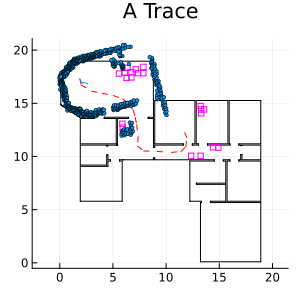

In [17]:
ch   = merge([constraints(t,_zs,_as) for t=0:T]...);
tr,w = generate(static_slam_model, (T, args...), ch)
plot_slam_trace!(tr)

In [18]:
#nbx
argdiffs(bs::Array{T,1}) where T <: Real = Tuple(map(b -> Bool(b) ? UnknownChange() : NoChange(), bs));
argdiffs([0,0.0,1.0, 1])

(NoChange(), NoChange(), UnknownChange(), UnknownChange())

## Inference

### Particle Filter with default proposal

In [19]:
N = 100 # 1_000 works decent

idealized = true
the_map   = idealized ? _segs : vcat(_segs, _boxes);

p0 = _ps[1]
x0_noise  = .4
hd0_noise = 12/360*2π

x_noise  = 0.5
hd_noise = 20/360*2π

wind    = 10
s_noise = 0.1
outlier = 1e-2
outlier_vol = 1e2

args = (
    the_map,                               # Map
    us_noisy,                              # Controls
    p0, x0_noise, hd0_noise,               # Pose prior model
    x_noise, hd_noise,                     # Motion model
    wind, s_noise, outlier, outlier_vol    # Sensor model
);

# Initialize the PF
ch    = constraints(0,_zs,_as);
state = pf_initialize(static_slam_model, (0, args...), ch, N);



diffs = argdiffs([1; zeros(length(args))])
times = []
for t=1:_T-1

    resample = effective_sample_size(state) < 0.2*N
    if resample
        # Perform residual resampling, pruning low-weight particles
        pf_resample!(state, :residual)
    end

    ch = constraints(t,_zs,_as);    
    sec = @elapsed pf_update!(state, (t, args...), diffs, ch)
    
    ms = sec*1_000
    push!(times, ms)
    println("$(resample), $(length(Set(state.parents))) ($(nice_f(ms)) ms)")
end

true, 2 (3214.89 ms)
true, 1 (212.28 ms)
true, 1 (125.67 ms)
true, 1 (125.59 ms)
true, 1 (123.43 ms)
true, 1 (125.28 ms)
true, 1 (126.93 ms)
true, 1 (130.56 ms)
true, 1 (132.91 ms)
true, 1 (127.26 ms)
true, 1 (130.97 ms)
true, 1 (362.47 ms)
true, 1 (127.35 ms)
true, 1 (126.13 ms)
true, 1 (125.91 ms)
true, 1 (125.12 ms)
true, 1 (126.72 ms)


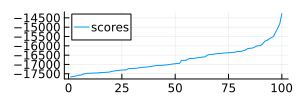

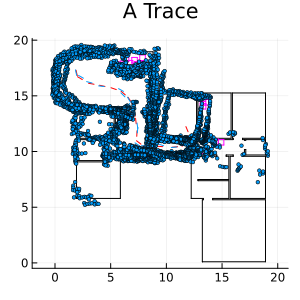

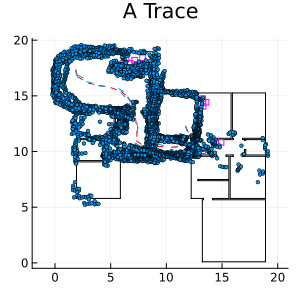

In [20]:
trs    = state.traces
ws     = state.log_weights
scores = get_score.(trs)

perm = sortperm(scores)

trs    = trs[perm]
ws     = ws[perm]
scores = scores[perm]

display(plot(scores, size=(300,100), label="scores"))

display(plot_slam_trace!(trs[1]))
display(plot_slam_trace!(trs[end]))

Particle filter with default upddate and additional MH drift move

In [21]:
#nbx
@gen function pose_drift_proposal(tr, x_noise, hd_noise, vars=[:x,:hd])
    
    T, = get_args(tr)
    p  = get_pose(tr,T+1)

    if :x in vars 
        x  = {add_addr_prefix(T, :pose => :x)}  ~ diagnormal(p.x, [x_noise, x_noise])
    end

    if :hd in vars 
        hd = {add_addr_prefix(T, :pose => :hd)} ~ normal(p.hd, hd_noise)
    end
    
    tr
end;

In [22]:
# Number of particles 
# and drifts
N = 10
D = 100

idealized = true
the_map   = idealized ? _segs : vcat(_segs, _boxes);

p0 = _ps[1]
x0_noise  = .4
hd0_noise = 12/360*2π

x_noise  = 0.5
hd_noise = 20/360*2π

wind = 10
s_noise = 0.1
outlier = 1e-2
outlier_vol = 1e2

args = (
    the_map,                               # Map
    us_noisy,                              # Controls
    p0, x0_noise, hd0_noise,               # Pose prior model
    x_noise, hd_noise,                     # Motion model
    wind, s_noise, outlier, outlier_vol    # Sensor model
);

# Initialize the PF
ch    = constraints(0,_zs,_as);
state = pf_initialize(static_slam_model, (0, args...), ch, N);


diffs = argdiffs([1; zeros(length(args))])
times = []
for t=1:_T-1

    scores = get_score.(state.traces)
    sec = @elapsed pf_rejuvenate!(state, mh, (pose_drift_proposal, (0.1, 2/180*π, [:x, :hd])), D)
    diff_scores = get_score.(state.traces) - scores
    println(minimum(diff_scores), " " , maximum(diff_scores))

    resample = effective_sample_size(state) < 0.2*N
    if resample
        # Perform residual resampling, pruning low-weight particles
        pf_resample!(state, :residual)
    end

    ch   = constraints(t,_zs,_as);    
    sec += @elapsed pf_update!(state, (t, args...), diffs, ch)    
    ms   = sec*1_000
    push!(times, ms)
    println("$(resample), $(length(Set(state.parents))) ($(nice_f(ms)) ms)")
end

259.4463933592881 2370.738398774036
true, 1 (4673.11 ms)
42.607852609996826 2954.739444146019
true, 1 (2195.87 ms)
991.0450796628259 2883.4474536732973
true, 1 (1629.48 ms)
773.2845836932706 2438.130891983293
true, 1 (1285.34 ms)
293.29620775405056 2554.647795219928
true, 1 (1627.96 ms)
245.926037192933 2743.4738971029255
true, 1 (1265.96 ms)
158.02482486295003 2763.843861985074
true, 1 (1533.24 ms)
207.844698528163 2866.080891774782
true, 1 (1581.49 ms)
110.64332499113516 2485.942143870867
true, 1 (1247.63 ms)
607.3213257288589 2646.668474179703
true, 1 (1601.89 ms)
220.7978776854943 2299.432490153142
true, 1 (1253.03 ms)
127.62160397693879 2579.0564767991523
true, 1 (1564.16 ms)
383.9684381385814 2943.1981849772087
true, 1 (1293.44 ms)
359.38927549127675 1213.5746653120868
true, 1 (1619.60 ms)
737.0760676084483 2344.3017783180703
true, 1 (1337.74 ms)
92.2125570592707 1865.4517995561023
true, 1 (1615.54 ms)
25.302463787529632 1575.775432200644
true, 1 (1321.80 ms)


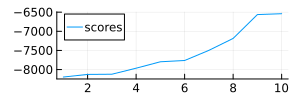

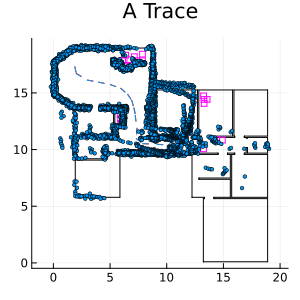

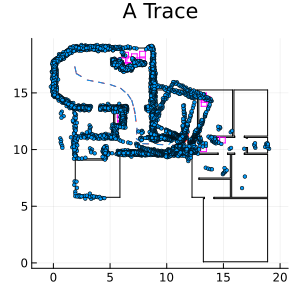

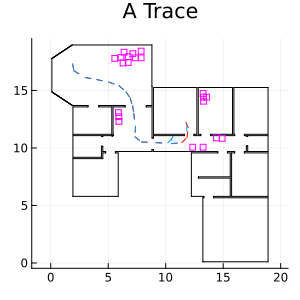

In [24]:
trs    = state.traces
ws     = state.log_weights
scores = get_score.(trs)

perm = sortperm(scores)

trs    = trs[perm]
ws     = ws[perm]
scores = scores[perm]

display(plot(scores, size=(300,100), label="scores"))
display(plot_slam_trace!(trs[1]))
display(plot_slam_trace!(trs[end], show_obs=true))
display(plot_slam_trace!(trs[end], show_obs=false))